In [11]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [45]:
transform = transforms.Compose([transforms.Resize((28, 28)),transforms.ToTensor(), #numpy array of range 0-255 --> float tensor of range 0-1
transforms.Normalize((.5,), (.5,))]) # norm. vals for each tensor of image size: channel, h, w. first bracket: mean val to normalise all channels in tensor image. second: SD. want range of 0-1 and -1-0
# reduces skewness and distorions is data - more effective learning

training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True) #subset of training data. changes if shuffle - prevents getting caught in local minima
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [46]:
def img_convert(tensor):
    image = tensor.clone().detach().numpy()
    #image = image.to(device)
    image = image.transpose(1,2,0) #MNIST - greyscale, 28*28px = 28*28*1 tensor. transpose tensor from c,w,h to w,h,c
    #print(image.shape)
    image = image * np.array((.5, .5, .5)) + np.array((.5, .5, .5)) #denorm.
    image = image.clip(0, 1) #make sure range is back to 0-1, vs -1-1
    return image

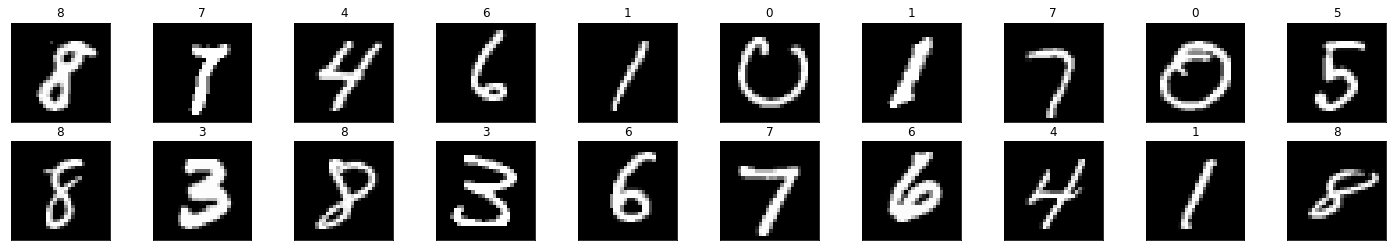

In [14]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (25, 4)) # w x h

for index in np.arange(20):
    ax = fig.add_subplot(2, 10, index + 1, xticks=[], yticks=[]) # r, c, index: pos. of subplot 
    plt.imshow(img_convert(images[index]))
    ax.set_title(labels[index].item())


In [15]:
class Classifier(nn.Module):
    def __init__(self, input_nodes, hidden_1, hidden_2, output_nodes):
        super().__init__()
        self.linear1 = nn.Linear(input_nodes, hidden_1)
        self.linear2 = nn.Linear(hidden_1, hidden_2)
        self.linear3 = nn.Linear(hidden_2, output_nodes)
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x) # want raw output (score) so no activ func. for cross entropy of multiclass dataset
        return x

In [16]:
model = Classifier(784, 125, 65, 10) #0: 28*28; 3: 10 nos therefore 10 outs.
#model.to(device)

In [17]:
criterion = nn.CrossEntropyLoss() #for classification problems with n clases
optimiser = torch.optim.Adam(model.parameters(), lr = .0001)

In [21]:
epochs = 15
running_loss_history = []
running_corrects_history = [] #accuracy per epoch
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = .0
    running_corrects = .0
    val_running_loss = .0
    val_running_corrects = .0
    

    for inputs, labels in training_loader: # flatten --> 784 cols for matrix multiplic. inputs are images
        inputs = inputs.view(inputs.shape[0], -1) #index 0 for colour, 1 for no. pixels - -1 = total val of second (1) index
        outputs = model(inputs) #scores
        loss = criterion(outputs, labels)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        _, preds = torch.max(outputs, 1) #top score per image. highest score in index x --> predict image belongs to class x
        running_corrects += torch.sum(preds == labels.data) #cmp to labels. if matching return 1 else 0. total
        running_loss += loss.item()


    else:
        with torch.no_grad(): #testing not training
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                val_running_loss += val_loss.item()


        epoch_loss = running_loss / len(training_loader)
        epoch_acc  = running_corrects.float() / len(training_loader) #no. batches
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc  = val_running_corrects.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss) # loss at every epoch
        val_running_corrects_history.append(val_epoch_acc)

        print("epoch :", (e+1))
        print("training loss: {:.4f}, acc {:.4f}".format(epoch_loss, epoch_acc.item()))
        print("validation loss: {:.4f}, acc {:.4f}".format(val_epoch_loss, val_epoch_acc.item()))

epoch :1
training loss: 0.3809, acc 89.2283
validation loss: 0.3256, acc 90.6100
epoch :2
training loss: 0.3176, acc 90.8317
validation loss: 0.2893, acc 91.5200
epoch :3
training loss: 0.2843, acc 91.8600
validation loss: 0.2612, acc 92.3300
epoch :4
training loss: 0.2598, acc 92.5050
validation loss: 0.2436, acc 92.9200
epoch :5
training loss: 0.2395, acc 93.1350
validation loss: 0.2323, acc 93.5700
epoch :6
training loss: 0.2225, acc 93.6067
validation loss: 0.2139, acc 93.7800
epoch :7
training loss: 0.2077, acc 94.0033
validation loss: 0.2015, acc 94.2800
epoch :8
training loss: 0.1938, acc 94.4350
validation loss: 0.1884, acc 94.4800
epoch :9
training loss: 0.1814, acc 94.7567
validation loss: 0.1819, acc 94.7900
epoch :10
training loss: 0.1697, acc 95.1617
validation loss: 0.1684, acc 95.0400
epoch :11
training loss: 0.1592, acc 95.3700
validation loss: 0.1620, acc 95.2100
epoch :12
training loss: 0.1504, acc 95.6850
validation loss: 0.1545, acc 95.4200
epoch :13
training loss: 

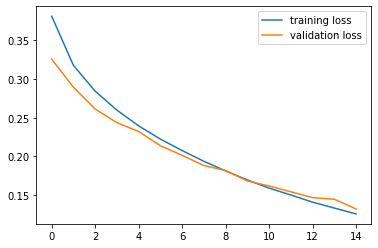

In [24]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

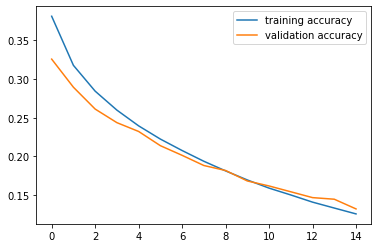

In [27]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

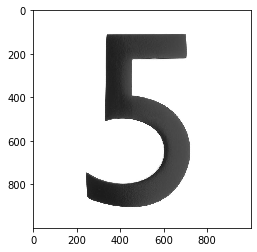

In [50]:
import requests
from PIL import Image
import PIL.ImageOps
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

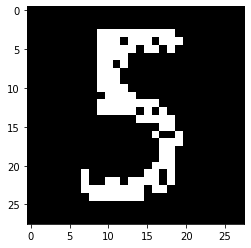

In [51]:
img = PIL.ImageOps.invert(img)
img = img.convert('1') # bilevel image?
img = transform(img)
plt.imshow(img_convert(img))

In [52]:
img = img.view(img.shape[0], -1) # 1*784 vector
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5


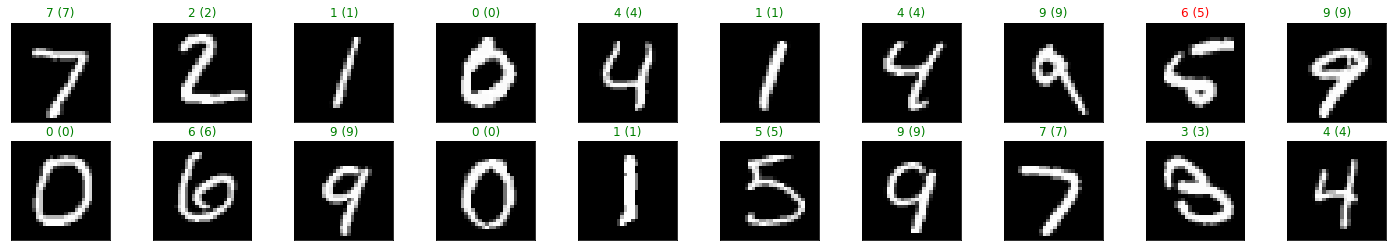

In [58]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize = (25, 4)) # w x h

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(img_convert(images[idx]))
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color = ("green" if preds[idx] == labels[idx] else "red"))